In [1]:
# Imports e paths
from pathlib import Path
import json, ast, re, unicodedata
from datetime import datetime, timezone

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.stats import spearmanr
from sklearn.linear_model import LinearRegression

# Este notebook deve estar na RAIZ do projeto
ROOT = Path.cwd()
DATA = ROOT / "data"
PROCESSED = DATA / "processed"
INTERIM = DATA / "interim"
RESULTS = ROOT / "results"
EXPORT = DATA / "exports" / "dashboard"

EXPORT.mkdir(parents=True, exist_ok=True)

print("ROOT:", ROOT)

ROOT: c:\Users\User\Desktop\TCC\Notebooks locais\analise_topicos_tcc


In [2]:
# Utilitários

def _latest_compare_csv(results_root: Path) -> Path | None:
    comp = results_root / "comparison"
    if not comp.exists(): return None
    runs = sorted(comp.glob("run_*"))
    if not runs: return None
    csv = runs[-1] / "all_trials_gr_rz.csv"
    return csv if csv.exists() else None

def _pick_best_bertopic(csv: Path, max_outliers=0.30, k_min=5):
    df = pd.read_csv(csv)
    cand = df[(df["method"]=="bertopic") & (df["K"]>=k_min)].copy()
    if "outliers_pct" in cand.columns:
        cand = cand[cand["outliers_pct"] <= max_outliers]
    if cand.empty:
        cand = df[df["method"]=="bertopic"].copy()
    cand = cand.sort_values(["RZ_index","GR_index"], ascending=False)
    assert not cand.empty, "Nenhum trial BERTopic encontrado no CSV."
    return cand.iloc[0].to_dict()

def _trial_dir_bertopic(bt_root: Path, run: str, trial: str) -> Path:
    if isinstance(run, str) and run.startswith("run_"):
        return bt_root / run / trial
    return bt_root / trial

def _parse_representation(val):
    if isinstance(val, (list, tuple)): return [str(x) for x in val]
    try:
        lst = ast.literal_eval(str(val))
        if isinstance(lst, (list, tuple)):
            return [str(x) for x in lst]
    except Exception:
        pass
    return [t for t in str(val).split() if t]

def _load_topic_labels(tdir: Path, topn_terms=5):
    labels = {}
    tip = tdir / "topic_info.csv"
    if tip.exists():
        df = pd.read_csv(tip)
        if "Topic" in df.columns:
            for _, row in df.iterrows():
                tid = int(row["Topic"])
                if tid == -1: 
                    continue
                name = str(row.get("Name", "")).strip()
                if name:
                    labels[tid] = name
                else:
                    reps = _parse_representation(row.get("Representation", ""))
                    if reps:
                        labels[tid] = ", ".join(reps[:topn_terms])
    # fallback com c_tf_idf + vocab
    missing = [t for t in range(max(labels.keys())+1 if labels else 0) if t not in labels]
    ctf_p, voc_p = tdir/"c_tf_idf.npy", tdir/"vocab.txt"
    if missing and ctf_p.exists() and voc_p.exists():
        ctf = np.load(ctf_p)
        vocab = [line.strip() for line in open(voc_p, encoding="utf-8")]
        for tid in range(ctf.shape[0]):
            if tid in labels: continue
            row = ctf[tid]
            idx = np.argsort(-row)[:topn_terms]
            labels[tid] = ", ".join(vocab[i] for i in idx)
    return labels

def _keyify_name(x: str) -> str:
    x = str(x).strip()
    x = re.sub(r"\s+", " ", x)
    x = re.sub(r"\s+([,.;:])", r"\1", x).replace(" ,", ",").replace(" .", ".")
    x = unicodedata.normalize("NFKD", x)
    x = "".join(c for c in x if not unicodedata.combining(c))
    x = x.lower()
    x = re.sub(r"[^a-z0-9 ,.\-]", "", x)
    return re.sub(r"\s+", " ", x).strip()

def _detect_year_column(df: pd.DataFrame) -> str:
    # tenta achar 'ano' ou 'year' em qualquer caixa/variação
    for c in df.columns:
        cl = c.lower().strip()
        if cl in {"ano","year","ano_defesa","ano_defesa_tcc","ano_publicacao"}: 
            return c
        if "ano" in cl or "year" in cl:
            return c
    raise AssertionError("Coluna de ano não encontrada no prep.csv. Esperado algo contendo 'ano' ou 'year'.")

def _year_to_int(s):
    try:
        return int(str(s)[:4])
    except Exception:
        return np.nan

def _soft_prob(counts: pd.Series | np.ndarray, alpha=0.5):
    arr = np.asarray(counts, dtype=float)
    arr = arr + alpha
    s = arr.sum()
    return arr / s if s > 0 else arr * np.nan

def _jsd(p, q, eps=1e-12):
    p = np.asarray(p, dtype=float); q = np.asarray(q, dtype=float)
    p = p / max(p.sum(), eps); q = q / max(q.sum(), eps)
    m = 0.5*(p+q)
    def _kl(a, b):
        a = np.where(a<=0, eps, a)
        b = np.where(b<=0, eps, b)
        return np.sum(a * np.log(a/b))
    return float(np.sqrt(0.5*_kl(p,m) + 0.5*_kl(q,m)))

def _ols_slope(x: np.ndarray, y: np.ndarray) -> float:
    x = np.asarray(x).reshape(-1,1)
    y = np.asarray(y).reshape(-1,1)
    if len(x) < 2: return np.nan
    model = LinearRegression().fit(x, y)
    return float(model.coef_[0,0])

In [3]:
# Seleção automática do melhor BERTopic
compare_csv = _latest_compare_csv(RESULTS)
assert compare_csv and compare_csv.exists(), "Rode compare_models antes (CSV de comparação não encontrado)."

best = _pick_best_bertopic(compare_csv, max_outliers=0.30, k_min=5)
best_run, best_trial, K = best["run"], best["trial"], int(best["K"])
print("Selecionado:", best_run, best_trial, "| K =", K)

BT_ROOT = PROCESSED / "bertopic"
TRIAL_DIR = _trial_dir_bertopic(BT_ROOT, best_run, best_trial)
assert TRIAL_DIR.exists(), f"Pasta do trial não encontrada: {TRIAL_DIR}"
print("TRIAL_DIR:", TRIAL_DIR)

# diretório de export desta análise temporal
OUT_DIR = EXPORT / "bertopic_time" / str(best_run) / str(best_trial)
OUT_DIR.mkdir(parents=True, exist_ok=True)

Selecionado: run_20250831T230602Z trial_24 | K = 12
TRIAL_DIR: c:\Users\User\Desktop\TCC\Notebooks locais\analise_topicos_tcc\data\processed\bertopic\run_20250831T230602Z\trial_24


In [4]:
# Carrega meta e doc→tópico
prep_csv = INTERIM / "bertopic" / "prep.csv"
assert prep_csv.exists(), f"Meta não encontrada: {prep_csv}"

meta = pd.read_csv(prep_csv, encoding="utf-8")
assert "DOC_ID" in meta.columns, "prep.csv precisa conter coluna DOC_ID"

# detecta ano e orientador
col_year = _detect_year_column(meta)
cand_orient_cols = [c for c in meta.columns if "orient" in c.lower()]
assert cand_orient_cols, "Coluna de orientador não encontrada (esperado algo contendo 'orient')."
col_orient = cand_orient_cols[0]

meta = meta[["DOC_ID", col_year, col_orient]].rename(columns={col_year:"ANO", col_orient:"orientador"})
meta["DOC_ID"] = meta["DOC_ID"].astype(int)
meta["ANO"] = meta["ANO"].map(_year_to_int).astype("Int64")
meta["orientador"] = meta["orientador"].astype(str).fillna("NA").str.strip()

# normaliza orientadores (consolida variações)
meta["_key"] = meta["orientador"].map(_keyify_name)
name_map = meta.groupby("_key")["orientador"].agg(lambda s: s.mode().iat[0] if not s.mode().empty else s.iloc[0]).to_dict()
meta["orientador"] = meta["_key"].map(name_map)
meta = meta.drop(columns=["_key"]).copy()

# Doc→tópico (ignora outliers -1)
labels = pd.read_csv(TRIAL_DIR / "doc_topics.csv", encoding="utf-8")
assert {"DOC_ID","topic"}.issubset(labels.columns), "doc_topics.csv precisa conter DOC_ID e topic"
labels["DOC_ID"] = labels["DOC_ID"].astype(int)
labels = labels[labels["topic"] != -1].copy()

# junção
df = labels.merge(meta, on="DOC_ID", how="inner")
assert not df.empty, "Junção vazia; verifique DOC_ID/ANO entre prep.csv e doc_topics.csv"

topic_labels = _load_topic_labels(TRIAL_DIR, topn_terms=5)
print("Intervalo de anos:", int(df["ANO"].min()), "→", int(df["ANO"].max()))
print("Docs com tópico:", len(df), "| K:", K, "| Orientadores:", df["orientador"].nunique())

Intervalo de anos: 2020 → 2024
Docs com tópico: 362 | K: 12 | Orientadores: 50


In [5]:
# Contagens por ano/tópico e totais por ano
ct_ty = df.groupby(["ANO","topic"]).size().rename("n").reset_index()
ct_y  = df.groupby("ANO").size().rename("n_docs_assigned")  # só docs com tópico (≠ -1)

# total de docs por ano (base completa)
year_tot = meta.groupby("ANO").size().rename("n_docs_total")

# matriz P(t|ano) com suavização
pivot_ty = ct_ty.pivot(index="ANO", columns="topic", values="n").fillna(0.0).sort_index()
p_t_given_year = pivot_ty.apply(lambda row: _soft_prob(row.values, alpha=0.5), axis=1, result_type="broadcast")
p_t_given_year.index = pivot_ty.index
p_t_given_year.columns = pivot_ty.columns

# tabela longa
long_topic_year = pivot_ty.stack().rename("n_topic").reset_index()
long_topic_year["p_topic_given_year"] = [
    float(p_t_given_year.loc[y, t]) for y, t in zip(long_topic_year["ANO"], long_topic_year["topic"])
]
long_topic_year["topic_label"] = long_topic_year["topic"].map(lambda t: topic_labels.get(int(t), f"topic_{t}"))

# cobertura por ano
coverage_year = pd.concat([year_tot, ct_y], axis=1).fillna(0)
coverage_year["coverage"] = coverage_year["n_docs_assigned"] / coverage_year["n_docs_total"].replace(0, np.nan)
coverage_year = coverage_year.reset_index().rename(columns={"index":"ANO"})

display(long_topic_year.head(10))
display(coverage_year.head())

,ANO,topic,n_topic,p_topic_given_year,topic_label
0,2020,0,2.0,0.081967,0_modelos_dados_linguagem_imagens
1,2020,1,1.0,0.049180,1_nuvem_recursos_dados_sistema
2,2020,2,4.0,0.147541,2_alunos_computao_programao_sistema
3,2020,3,1.0,0.049180,3_software_projetos_cdigo_bugs
4,2020,4,1.0,0.049180,4_dados_digital_sobre_privacidade
5,2020,5,1.0,0.049180,5_sade_animais_pandemia_dados
6,2020,6,1.0,0.049180,6_software_empresas_objetivo_vulnerabilidades
7,2020,7,2.0,0.081967,7_dados_logs_sistemas_banco
8,2020,8,0.0,0.016393,8_dados_meio_aplicativos_anlise
9,2020,9,0.0,0.016393,9_ensino_alunos_atividades_evaso


,ANO,n_docs_total,n_docs_assigned,coverage
0,2020,30,25,0.833333
1,2021,86,75,0.872093
2,2022,78,68,0.871795
3,2023,146,125,0.856164
4,2024,83,69,0.831325


In [6]:
# Tendências por tópico: slope (OLS) de p(t|ano), delta, "CAGR" aprox., Spearman rho

years = np.array(sorted(long_topic_year["ANO"].dropna().unique()), dtype=float)
trend_rows = []
for t in sorted(p_t_given_year.columns):
    series = p_t_given_year[t].dropna()
    yy = series.index.values.astype(float)
    pp = series.values.astype(float)

    if len(pp) < 2:
        slope = rho = np.nan
        delta = np.nan
        cagr = np.nan
    else:
        slope = _ols_slope(yy, pp)                     # variação de proporção por ano
        delta = float(pp[-1] - pp[0])                  # variação absoluta no período
        # CAGR aproximado sobre proporções, com epsilon para zeros
        eps = 1e-6
        years_span = max(int(yy[-1]-yy[0]), 1)
        cagr = float(((pp[-1]+eps)/(pp[0]+eps))**(1/years_span) - 1)
        rho, _ = spearmanr(yy, pp, nan_policy="omit")

    trend_rows.append({
        "topic": int(t),
        "topic_label": topic_labels.get(int(t), f"topic_{t}"),
        "years_min": int(yy[0]) if len(series)>0 else np.nan,
        "years_max": int(yy[-1]) if len(series)>0 else np.nan,
        "p_first": float(pp[0]) if len(series)>0 else np.nan,
        "p_last": float(pp[-1]) if len(series)>0 else np.nan,
        "delta": delta,
        "slope_per_year": slope,
        "cagr_approx": cagr,
        "spearman_rho": float(rho) if 'rho' in locals() else np.nan
    })

topic_trends = pd.DataFrame(trend_rows).sort_values(["slope_per_year","delta"], ascending=False)
display(topic_trends.head(10))

,topic,topic_label,years_min,years_max,p_first,p_last,delta,slope_per_year,cagr_approx,spearman_rho
0,0,0_modelos_dados_linguagem_imagens,2020,2024,0.081967,0.208054,0.126086,0.032085,0.262214,0.9
1,1,1_nuvem_recursos_dados_sistema,2020,2024,0.049180,0.140940,0.091759,0.021783,0.301095,0.8
6,6,6_software_empresas_objetivo_vulnerabilidades,2020,2024,0.049180,0.100671,0.051491,0.014867,0.196127,0.8
8,8,8_dados_meio_aplicativos_anlise,2020,2024,0.016393,0.046980,0.030586,0.010767,0.301086,0.7
5,5,5_sade_animais_pandemia_dados,2020,2024,0.049180,0.114094,0.064914,0.010760,0.234146,0.3
9,9,9_ensino_alunos_atividades_evaso,2020,2024,0.016393,0.046980,0.030586,0.006460,0.301086,0.7
4,4,4_dados_digital_sobre_privacidade,2020,2024,0.049180,0.114094,0.064914,0.006267,0.234146,0.3
3,3,3_software_projetos_cdigo_bugs,2020,2024,0.049180,0.087248,0.038068,-0.001296,0.154092,0.1
2,2,2_alunos_computao_programao_sistema,2020,2024,0.147541,0.100671,-0.046870,-0.008056,-0.091137,-0.7
7,7,7_dados_logs_sistemas_banco,2020,2024,0.081967,0.033557,-0.048410,-0.012300,-0.200096,-1.0


In [7]:
# P(tópico|orientador, ano). Exigimos um mínimo de docs/ano para estabilidade.

MIN_DOCS_ORIENTADOR_ANO = 3
alpha = 0.5  # suavização das probabilidades

# contagens por orientador/ano/tópico
ct_oyt = df.groupby(["orientador","ANO","topic"]).size().rename("n").reset_index()
ct_oy  = df.groupby(["orientador","ANO"]).size().rename("n_oy").reset_index()

# somente cels com pelo menos MIN_DOCS_ORIENTADOR_ANO
valid_pairs = set(
    ct_oy[ct_oy["n_oy"] >= MIN_DOCS_ORIENTADOR_ANO][["orientador","ANO"]] \
        .itertuples(index=False, name=None)
)

rows_p = []
for (o, y), block in ct_oyt.groupby(["orientador","ANO"]):
    if (o, y) not in valid_pairs:
        continue
    # vetor em todos os tópicos (0..K-1)
    counts = np.zeros(K, dtype=float)
    for _, r in block.iterrows():
        counts[int(r["topic"])] = r["n"]
    probs = _soft_prob(counts, alpha=alpha)
    for t in range(K):
        rows_p.append({
            "orientador": o,
            "ANO": int(y),
            "topic": int(t),
            "topic_label": topic_labels.get(int(t), f"topic_{t}"),
            "P_topic_given_orientador_year": float(probs[t]),
            "n_docs_orientador_year": int(ct_oy[(ct_oy["orientador"]==o)&(ct_oy["ANO"]==y)]["n_oy"].iloc[0])
        })

orientador_topic_year = pd.DataFrame(rows_p).sort_values(["orientador","ANO","P_topic_given_orientador_year"], ascending=[True, True, False])
display(orientador_topic_year.head(10))

# Top topic por orientador/ano
top_by_year = (
    orientador_topic_year
    .sort_values(["orientador","ANO","P_topic_given_orientador_year"], ascending=[True, True, False])
    .groupby(["orientador","ANO"], as_index=False)
    .first()[["orientador","ANO","topic","topic_label","P_topic_given_orientador_year","n_docs_orientador_year"]]
)
display(top_by_year.head(10))

# Métrica de mudança de preferência: nº de trocas do top topic e JSD médio entre anos consecutivos
shift_rows = []
for o, g in orientador_topic_year.groupby("orientador"):
    years_sorted = sorted(g["ANO"].unique())
    if len(years_sorted) < 2: 
        continue

    # seq de top topics
    tops = top_by_year[top_by_year["orientador"]==o].sort_values("ANO")
    seq = tops["topic"].tolist()
    switches = int(np.sum(np.array(seq[1:]) != np.array(seq[:-1])))

    # JSD médio e máximo entre distribuições consecutivas P(t|o,ano)
    jsds = []
    for y1, y2 in zip(years_sorted[:-1], years_sorted[1:]):
        p1 = orientador_topic_year[(orientador_topic_year["orientador"]==o)&(orientador_topic_year["ANO"]==y1)] \
                .sort_values("topic")["P_topic_given_orientador_year"].values
        p2 = orientador_topic_year[(orientador_topic_year["orientador"]==o)&(orientador_topic_year["ANO"]==y2)] \
                .sort_values("topic")["P_topic_given_orientador_year"].values
        if len(p1)==K and len(p2)==K:
            jsds.append(_jsd(p1, p2))
    mean_jsd = float(np.mean(jsds)) if jsds else np.nan
    max_jsd  = float(np.max(jsds))  if jsds else np.nan

    shift_rows.append({
        "orientador": o,
        "years_covered": len(years_sorted),
        "first_year": int(years_sorted[0]),
        "last_year": int(years_sorted[-1]),
        "top_switches": switches,
        "mean_jsd_consecutive": mean_jsd,
        "max_jsd_consecutive": max_jsd,
        "last_top_topic": int(tops.iloc[-1]["topic"]),
        "last_top_label": str(tops.iloc[-1]["topic_label"])
    })

orientador_shift_summary = pd.DataFrame(shift_rows).sort_values(
    ["top_switches","mean_jsd_consecutive"], ascending=[False, False]
)
display(orientador_shift_summary.head(10))

# Slopes por orientador-tópico (tendência de preferência)
slope_rows = []
for (o, t), g in orientador_topic_year.groupby(["orientador","topic"]):
    g = g.sort_values("ANO")
    if len(g) < 2: 
        continue
    slope = _ols_slope(g["ANO"].values.astype(float), g["P_topic_given_orientador_year"].values.astype(float))
    slope_rows.append({
        "orientador": o,
        "topic": int(t),
        "topic_label": topic_labels.get(int(t), f"topic_{t}"),
        "years": len(g),
        "slope_per_year": float(slope),
        "p_first": float(g.iloc[0]["P_topic_given_orientador_year"]),
        "p_last": float(g.iloc[-1]["P_topic_given_orientador_year"])
    })

orientador_topic_slopes = pd.DataFrame(slope_rows).sort_values(
    ["slope_per_year","years"], ascending=[False, False]
)
display(orientador_topic_slopes.head(10))

,orientador,ANO,topic,topic_label,P_topic_given_orientador_year,n_docs_orientador_year
6,"ALVES, Everton Leandro Galdino.",2023,6,6_software_empresas_objetivo_vulnerabilidades,0.269231,7
0,"ALVES, Everton Leandro Galdino.",2023,0,0_modelos_dados_linguagem_imagens,0.115385,7
2,"ALVES, Everton Leandro Galdino.",2023,2,2_alunos_computao_programao_sistema,0.115385,7
3,"ALVES, Everton Leandro Galdino.",2023,3,3_software_projetos_cdigo_bugs,0.115385,7
5,"ALVES, Everton Leandro Galdino.",2023,5,5_sade_animais_pandemia_dados,0.115385,7
1,"ALVES, Everton Leandro Galdino.",2023,1,1_nuvem_recursos_dados_sistema,0.038462,7
4,"ALVES, Everton Leandro Galdino.",2023,4,4_dados_digital_sobre_privacidade,0.038462,7
7,"ALVES, Everton Leandro Galdino.",2023,7,7_dados_logs_sistemas_banco,0.038462,7
8,"ALVES, Everton Leandro Galdino.",2023,8,8_dados_meio_aplicativos_anlise,0.038462,7
9,"ALVES, Everton Leandro Galdino.",2023,9,9_ensino_alunos_atividades_evaso,0.038462,7


,orientador,ANO,topic,topic_label,P_topic_given_orientador_year,n_docs_orientador_year
0,"ALVES, Everton Leandro Galdino.",2023,6,6_software_empresas_objetivo_vulnerabilidades,0.269231,7
1,"ANDRADE, Nazareno Ferreira de.",2021,4,4_dados_digital_sobre_privacidade,0.250000,4
2,"ANDRADE, Wilkerson de Lucena.",2023,1,1_nuvem_recursos_dados_sistema,0.150000,4
3,"ARAÚJO, Eliane Cristina de.",2023,2,2_alunos_computao_programao_sistema,0.166667,3
4,"ARAÚJO, Joseana Macêdo Fechine Régis de.",2021,1,1_nuvem_recursos_dados_sistema,0.250000,4
5,"ARAÚJO, Joseana Macêdo Fechine Régis de.",2022,0,0_modelos_dados_linguagem_imagens,0.227273,5
6,"BAPTISTA, Cláudio de Souza.",2021,1,1_nuvem_recursos_dados_sistema,0.150000,4
7,"BAPTISTA, Cláudio de Souza.",2022,0,0_modelos_dados_linguagem_imagens,0.150000,4
8,"BAPTISTA, Cláudio de Souza.",2024,1,1_nuvem_recursos_dados_sistema,0.192308,7
9,"BARROS, Marcelo Alves de.",2023,5,5_sade_animais_pandemia_dados,0.250000,4


,orientador,years_covered,first_year,last_year,top_switches,mean_jsd_consecutive,max_jsd_consecutive,last_top_topic,last_top_label
11,"MOURA, José Antão Beltrão.",3,2021,2023,2,0.328562,0.332055,3,3_software_projetos_cdigo_bugs
9,"MONTEIRO, João Arthur Brunet.",3,2021,2023,2,0.288698,0.325788,6,6_software_empresas_objetivo_vulnerabilidades
14,"SILVA, Thiago Emmanuel Pereira da Cunha.",3,2021,2023,2,0.277884,0.307166,1,1_nuvem_recursos_dados_sistema
1,"BAPTISTA, Cláudio de Souza.",3,2021,2024,2,0.277175,0.280156,1,1_nuvem_recursos_dados_sistema
8,"MASSONI, Tiago Lima.",4,2021,2024,2,0.253877,0.292793,2,2_alunos_computao_programao_sistema
5,"CAMPOS, Lívia Maria Rodrigues Sampaio.",3,2021,2024,2,0.233057,0.241120,2,2_alunos_computao_programao_sistema
6,"GHEYI, Rohit.",2,2020,2024,1,0.381788,0.381788,3,3_software_projetos_cdigo_bugs
10,"MORAIS, Fábio Jorge Almeida.",2,2023,2024,1,0.288800,0.288800,0,0_modelos_dados_linguagem_imagens
7,"GOMES, Herman Martins.",4,2020,2024,1,0.278762,0.320186,0,0_modelos_dados_linguagem_imagens
3,"BRUNET, João Arthur Monteiro.",2,2023,2024,1,0.276115,0.276115,0,0_modelos_dados_linguagem_imagens


,orientador,topic,topic_label,years,slope_per_year,p_first,p_last
120,"MORAIS, Fábio Jorge Almeida.",0,0_modelos_dados_linguagem_imagens,2,0.197917,0.093750,0.291667
36,"BRUNET, João Arthur Monteiro.",0,0_modelos_dados_linguagem_imagens,2,0.128205,0.038462,0.166667
124,"MORAIS, Fábio Jorge Almeida.",4,4_dados_digital_sobre_privacidade,2,0.114583,0.093750,0.208333
25,"BRITO, Andrey Elísio Monteiro.",1,1_nuvem_recursos_dados_sistema,3,0.097222,0.055556,0.250000
2,"ARAÚJO, Joseana Macêdo Fechine Régis de.",2,2_alunos_computao_programao_sistema,2,0.086364,0.050000,0.136364
9,"ARAÚJO, Joseana Macêdo Fechine Régis de.",9,9_ensino_alunos_atividades_evaso,2,0.086364,0.050000,0.136364
159,"RAMALHO, Franklin de Souza.",3,3_software_projetos_cdigo_bugs,3,0.079365,0.166667,0.388889
0,"ARAÚJO, Joseana Macêdo Fechine Régis de.",0,0_modelos_dados_linguagem_imagens,2,0.077273,0.150000,0.227273
75,"GHEYI, Rohit.",3,3_software_projetos_cdigo_bugs,2,0.073611,0.055556,0.350000
135,"MOURA, José Antão Beltrão.",3,3_software_projetos_cdigo_bugs,3,0.062500,0.125000,0.250000


In [8]:
# Exports
(long_topic_year
 .sort_values(["ANO","topic"])
 .to_csv(OUT_DIR/"topic_by_year.csv", index=False, encoding="utf-8"))

(topic_trends
 .to_csv(OUT_DIR/"topic_trend_summary.csv", index=False, encoding="utf-8"))

(coverage_year
 .to_csv(OUT_DIR/"coverage_by_year.csv", index=False, encoding="utf-8"))

(orientador_topic_year
 .to_csv(OUT_DIR/"orientador_topic_year.csv", index=False, encoding="utf-8"))

(top_by_year
 .to_csv(OUT_DIR/"orientador_top_topic_by_year.csv", index=False, encoding="utf-8"))

(orientador_shift_summary
 .to_csv(OUT_DIR/"orientador_shift_summary.csv", index=False, encoding="utf-8"))

(orientador_topic_slopes
 .to_csv(OUT_DIR/"orientador_topic_slopes.csv", index=False, encoding="utf-8"))

# Metadados
with open(OUT_DIR/"selection.json","w",encoding="utf-8") as f:
    json.dump({
        "selected_run": best_run,
        "selected_trial": best_trial,
        "K": int(K),
        "source_compare_csv": str(compare_csv),
        "timestamp_utc": datetime.now(timezone.utc).isoformat()
    }, f, ensure_ascii=False, indent=2)

print("Arquivos salvos em:", OUT_DIR)

Arquivos salvos em: c:\Users\User\Desktop\TCC\Notebooks locais\analise_topicos_tcc\data\exports\dashboard\bertopic_time\run_20250831T230602Z\trial_24


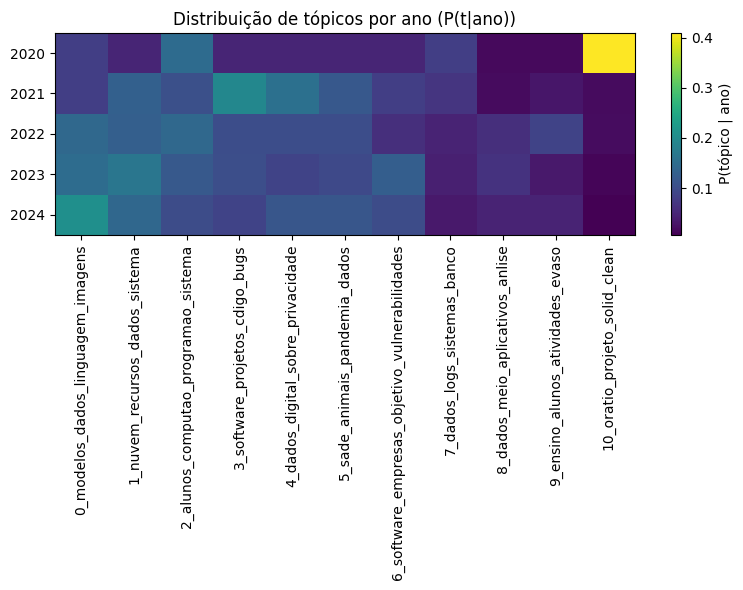

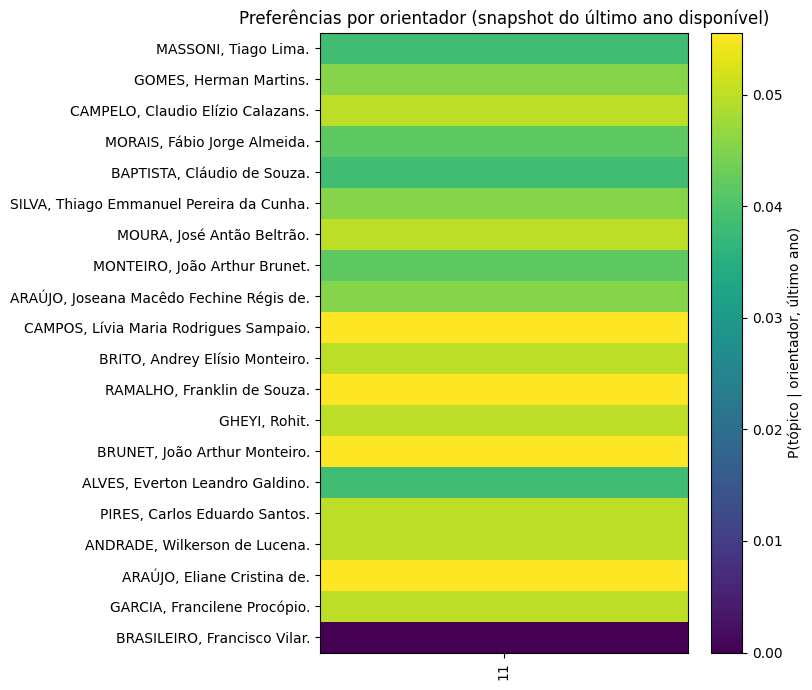

Figuras salvas em: c:\Users\User\Desktop\TCC\Notebooks locais\analise_topicos_tcc\data\exports\dashboard\bertopic_time\run_20250831T230602Z\trial_24


In [9]:
# Heatmap 1: P(t|ano)
plt.figure(figsize=(max(8, len(p_t_given_year.columns)*0.6), max(6, len(p_t_given_year.index)*0.5)))
plt.imshow(p_t_given_year.values, aspect='auto', interpolation='nearest')
plt.colorbar(label="P(tópico | ano)")
plt.yticks(range(len(p_t_given_year.index)), p_t_given_year.index)
plt.xticks(range(len(p_t_given_year.columns)), 
           [topic_labels.get(int(t), t) for t in p_t_given_year.columns], rotation=90)
plt.title("Distribuição de tópicos por ano (P(t|ano))")
plt.tight_layout()
plt.savefig(OUT_DIR/"heatmap_topic_by_year.png", dpi=150)
plt.show()

# Heatmap 2: para N orientadores com mais docs, agregando últimos N anos
TOP_ORI = 20
ori_order = df["orientador"].value_counts().head(TOP_ORI).index.tolist()
sub = orientador_topic_year[orientador_topic_year["orientador"].isin(ori_order)]
# usa último ano de cada orientador só para um snapshot comparável
snap = sub.sort_values(["orientador","ANO"]).groupby("orientador").tail(1)
mat = (snap.pivot(index="orientador", columns="topic", values="P_topic_given_orientador_year")
           .reindex(ori_order).fillna(0))

plt.figure(figsize=(max(8, len(mat.columns)*0.6), max(6, len(mat.index)*0.35)))
plt.imshow(mat.values, aspect='auto', interpolation='nearest')
plt.colorbar(label="P(tópico | orientador, último ano)")
plt.yticks(range(len(mat.index)), mat.index)
plt.xticks(range(len(mat.columns)), [topic_labels.get(int(t), t) for t in mat.columns], rotation=90)
plt.title("Preferências por orientador (snapshot do último ano disponível)")
plt.tight_layout()
plt.savefig(OUT_DIR/"heatmap_orientador_snapshot.png", dpi=150)
plt.show()

print("Figuras salvas em:", OUT_DIR)

In [ ]:
import pandas as pd
import numpy as np
from pathlib import Path
import re
import unicodedata

# ------------------------------------------------------------------
# Utilitários mínimos (caso a célula anterior não tenha sido executada)
# ------------------------------------------------------------------
def _norm_text(s: str) -> str:
    if pd.isna(s):
        return ""
    s = str(s)
    s = unicodedata.normalize("NFKD", s).encode("ascii", "ignore").decode("ascii")
    s = s.lower()
    s = re.sub(r"\s+", " ", s).strip()
    return s

def _find_col(df: pd.DataFrame, candidates: list[str]) -> str | None:
    cols = list(df.columns)
    norm_cols = [_norm_text(c) for c in cols]
    for cand in candidates:
        c0 = _norm_text(cand)
        for i, c in enumerate(norm_cols):
            if c == c0:
                return cols[i]
    for i, c in enumerate(norm_cols):
        for cand in candidates:
            if _norm_text(cand) in c:
                return cols[i]
    return None

def _is_empty_text(x) -> bool:
    if pd.isna(x):
        return True
    s = str(x)
    s = re.sub(r"\s+", " ", s).strip()
    no_punct = re.sub(r"[^\w]+", "", s, flags=re.UNICODE)
    return len(s) == 0 or len(no_punct) == 0

# ------------------------------------------------------------------
# Carrega CSV bruto (não altera o pipeline; apenas documenta e exporta tabelas de impacto)
# ------------------------------------------------------------------
CSV_PATH = (ROOT / "data" / "raw" / "tccs.csv") if "ROOT" in globals() else Path("data/raw/tccs.csv")
df0 = pd.read_csv(CSV_PATH, encoding="utf-8", engine="python")

# Identifica colunas relevantes
resumo_col     = _find_col(df0, ["resumo", "resumo_pt", "resumo_texto", "abstract", "summary"])
orientador_col = _find_col(df0, ["orientador", "orientadores", "advisor", "orientador_nome"])
id_col         = _find_col(df0, ["DOC_ID", "doc_id", "id", "codigo", "codigoid"])
titulo_col     = _find_col(df0, ["titulo", "título", "title"])
ano_col        = _find_col(df0, ["ano", "year"])

assert resumo_col is not None, "Coluna de resumo não encontrada."
assert orientador_col is not None, "Coluna de orientador não encontrada."

# Máscara de resumos vazios
mask_empty = df0[resumo_col].apply(_is_empty_text)
total = len(df0)
n_empty = int(mask_empty.sum())
pct_empty = mask_empty.mean()

print(f"[Resumo vazio] {n_empty} de {total} registros ({pct_empty:.1%}).")
print("Os 14 identificados serão EXCLUÍDOS APENAS de análises que exigem texto, mantendo-os para metadados.\n")

# ------------------------------------------------------------------
# Sumário por ANO
# ------------------------------------------------------------------
if ano_col is None:
    df_year = pd.DataFrame({"ano":"NA", "total": total, "vazios": n_empty})
    df_year["pct_vazios"] = df_year["vazios"] / df_year["total"]
else:
    tmp = df0.copy()
    tmp[ano_col] = pd.to_numeric(tmp[ano_col], errors="coerce")
    g = tmp.groupby(ano_col, dropna=False)
    df_year = pd.DataFrame({
        "total": g.size(),
        "vazios": g[resumo_col].apply(lambda s: s.apply(_is_empty_text).sum())
    }).reset_index().rename(columns={ano_col: "ano"})
    df_year["pct_vazios"] = df_year["vazios"] / df_year["total"]
    df_year = df_year.sort_values("ano", na_position="last")

# ------------------------------------------------------------------
# Sumário por ORIENTADOR (literal, sem canonicalização)
# ------------------------------------------------------------------
g2 = df0.groupby(orientador_col, dropna=False)
df_orient = pd.DataFrame({
    "total": g2.size(),
    "vazios": g2[resumo_col].apply(lambda s: s.apply(_is_empty_text).sum())
}).reset_index().rename(columns={orientador_col: "orientador"})
df_orient["pct_vazios"] = df_orient["vazios"] / df_orient["total"]
df_orient = df_orient.sort_values(["vazios","total","orientador"], ascending=[False, False, True])

# ------------------------------------------------------------------
# Exporta documentação de impacto e lista de exclusões
# ------------------------------------------------------------------
quality_dir = (ROOT / "data" / "interim" / "quality") if "ROOT" in globals() else Path("data/interim/quality")
quality_dir.mkdir(parents=True, exist_ok=True)

df_year.to_csv(quality_dir / "missing_abstracts_by_year.csv", index=False, encoding="utf-8")
df_orient.to_csv(quality_dir / "missing_abstracts_by_orientador.csv", index=False, encoding="utf-8")

cols_excluir = [c for c in [id_col, titulo_col, ano_col, orientador_col, resumo_col] if c is not None]
df_excl = df0.loc[mask_empty, cols_excluir].copy()
df_excl.insert(0, "motivo_exclusao", "sem_texto")
df_excl.to_csv(quality_dir / "excluded_no_abstract.csv", index=False, encoding="utf-8")

# Conjunto de IDs válidos para análises textuais (se houver DOC_ID)
if id_col is not None:
    valid_ids = df0.loc[~mask_empty, id_col]
    valid_ids.to_frame(name=id_col).to_csv(quality_dir / "valid_doc_ids.csv", index=False, encoding="utf-8")

# ------------------------------------------------------------------
# Exibição resumida (amostra) para inspeção rápida no notebook
# ------------------------------------------------------------------
from IPython.display import display

print("[Impacto por ano] (amostra)")
display(df_year.head(10))

print("\n[Orientadores com mais resumos vazios] (top 15)")
display(df_orient.head(15))

print("\n[Registros excluídos de etapas textuais] (amostra)")
display(df_excl.head(15))

# Observação para o texto do artigo (Seção 4.1):
print(
    "\nNota metodológica sugerida para 4.1: "
    f"“Foram identificados {n_empty}/{total} (={pct_empty:.1%}) registros sem texto de resumo. "
    "Esses registros foram mantidos para análises baseadas em metadados (ano, orientador etc.), "
    "mas excluídos exclusivamente das etapas que requerem conteúdo textual. "
    "Relatamos a distribuição dessa ausência por ano e por orientador nos materiais suplementares.”"
)


[Resumo vazio] 14 de 423 registros (3.3%).
Os 14 identificados serão EXCLUÍDOS APENAS de análises que exigem texto, mantendo-os para metadados.

[Impacto por ano] (amostra)


,ano,total,vazios,pct_vazios
0,2020,30,12,0.400000
1,2021,86,1,0.011628
2,2022,78,1,0.012821
3,2023,146,0,0.000000
4,2024,83,0,0.000000



[Orientadores com mais resumos vazios] (top 15)


,orientador,total,vazios,pct_vazios
36,"GOMES, Herman Martins.",26,2,0.076923
75,"SILVA, Thiago Emmanuel Pereira da Cunha.",19,2,0.105263
35,"GHEYI, Rohit.",8,2,0.250000
58,"OLIVEIRA, Maxwell Guimarães de.",5,1,0.200000
67,"RAMALHO, Franklin de Souza.",2,1,0.500000
7,"ARAÚJO, Eliane Cristina de.",1,1,1.000000
14,"BRASILEIRO, Francisco Vilar.",1,1,1.000000
31,"GHEYI , Rohit.",1,1,1.000000
37,"GOMES, Herman Martins.",1,1,1.000000
55,"MOURA, José Antão Beltrão.",1,1,1.000000



[Registros excluídos de etapas textuais] (amostra)


,motivo_exclusao,titulo,ano,orientador,resumo
280,sem_texto,A case study of proactive auto-scaling for an ...,2022,"SILVA, Thiago Emmanuel Pereira da Cunha.",NaN
346,sem_texto,Using a thesaurus in traceability recovery bet...,2020,"RAMALHO, Franklin de Souza.",NaN
349,sem_texto,Performance analysis between Apache Kafka and ...,2020,"SILVA, Thiago Emmanuel Pereira da Cunha.",NaN
350,sem_texto,A resilient and cloud-based batch processing s...,2020,"BRASILEIRO, Francisco Vilar.",NaN
352,sem_texto,Evaluating Karate-do movements using Kinect V2...,2020,"GOMES, Herman Martins.",NaN
355,sem_texto,Evolucionary procedural content generation for...,2020,"GOMES, Herman Martins.",NaN
357,sem_texto,Implementação do garbage collector control int...,2020,"SILVA, Thiago Emmanuel Pereira da Cunha.",NaN
358,sem_texto,Proposal of a low­cost device to support remot...,2020,"GOMES, Herman Martins.",NaN
363,sem_texto,Most higher mutants are useless for method-lev...,2020,"GHEYI, Rohit.",NaN
364,sem_texto,Challenges in the use of Scrum in Global Softw...,2020,"MOURA, José Antão Beltrão.",NaN



Nota metodológica sugerida para 4.1: “Foram identificados 14/423 (=3.3%) registros sem texto de resumo. Esses registros foram mantidos para análises baseadas em metadados (ano, orientador etc.), mas excluídos exclusivamente das etapas que requerem conteúdo textual. Relatamos a distribuição dessa ausência por ano e por orientador nos materiais suplementares.”


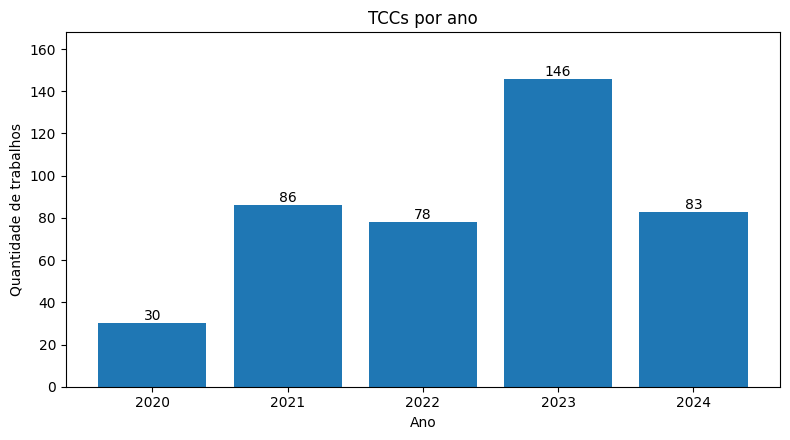

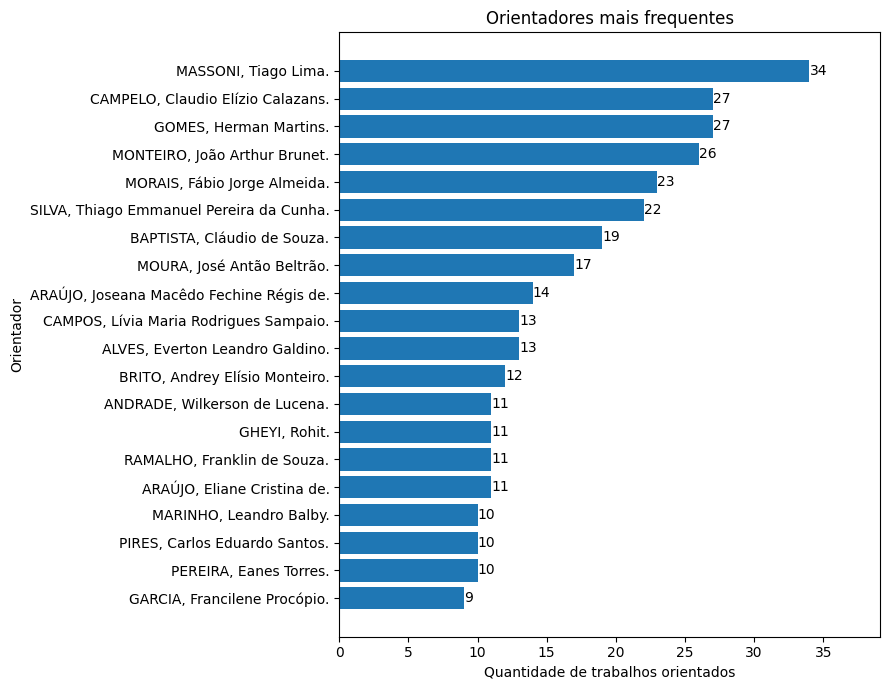

In [6]:
# --- Gráficos: TCCs por ano e orientadores (com nome canonizado) ---
# Agora com rótulos numéricos acima/depois de cada barra.

import pandas as pd
import numpy as np
from pathlib import Path
import re, unicodedata
import matplotlib.pyplot as plt
from collections import Counter, defaultdict

# -----------------------------------------------------------
# Caminhos
# -----------------------------------------------------------
ROOT_ = ROOT if "ROOT" in globals() else Path(".")
CAND_PATHS = [
    ROOT_ / "data" / "raw" / "csv" / "tccs.csv",
    ROOT_ / "data" / "raw" / "tccs.csv",
]
for p in CAND_PATHS:
    if p.exists():
        CSV_PATH = p
        break
else:
    raise FileNotFoundError("Não encontrei data/raw/csv/tccs.csv nem data/raw/tccs.csv.")

OUT_DIR = ROOT_ / "data" / "interim"
(OUT_DIR / "figures").mkdir(parents=True, exist_ok=True)

# -----------------------------------------------------------
# Utilitários
# -----------------------------------------------------------
def _norm_text(s: str) -> str:
    if pd.isna(s):
        return ""
    s = str(s)
    s = unicodedata.normalize("NFKD", s).encode("ascii", "ignore").decode("ascii")
    s = s.lower()
    s = re.sub(r"\s+", " ", s).strip()
    return s

def _find_col(df: pd.DataFrame, candidates: list[str]) -> str | None:
    cols = list(df.columns)
    norm_cols = [_norm_text(c) for c in cols]
    # match exato
    for cand in candidates:
        c0 = _norm_text(cand)
        for i, c in enumerate(norm_cols):
            if c == c0:
                return cols[i]
    # por substring
    for i, c in enumerate(norm_cols):
        for cand in candidates:
            if _norm_text(cand) in c:
                return cols[i]
    return None

# --- Nome de pessoa: normalização e fingerprint ---
HONORIFICS = r"(prof(essor)?a?|dr|doutor(a)?|me|ms|msc|phd|orientador(a)?|coorientador(a)?)"

def _normalize_name(name: str) -> str:
    s = _norm_text(name)
    s = re.sub(rf"\b{HONORIFICS}\b\.?", "", s)
    s = re.sub(r"[^\w\s]", " ", s)                    # remove pontuação
    s = re.sub(r"\b(de|da|do|das|dos|e)\b", " ", s)   # remove preposições comuns
    s = re.sub(r"\s+", " ", s).strip()
    return s

def _name_tokens(name: str) -> list[str]:
    s = _normalize_name(name)
    return [t for t in s.split() if len(t) > 1]

def _name_fingerprint(name: str) -> str:
    toks = _name_tokens(name)
    return " ".join(sorted(toks))  # fingerprint = tokens ordenados (insensível à ordem original)

def _first_last_tokens(name: str) -> tuple[str,str]:
    toks = _name_tokens(name)
    return (toks[0], toks[-1]) if toks else ("","")

# -----------------------------------------------------------
# Carrega CSV e identifica colunas
# -----------------------------------------------------------
df = pd.read_csv(CSV_PATH, encoding="utf-8", engine="python")
ano_col = _find_col(df, ["ano", "year"])
orientador_col = _find_col(df, ["orientador", "orientadores", "advisor", "orientador_nome"])

assert ano_col is not None, "Coluna de ano não encontrada."
assert orientador_col is not None, "Coluna de orientador não encontrada."

# -----------------------------------------------------------
# 1) TCCs por ano (com rótulos nas barras)
# -----------------------------------------------------------
df_year = df.copy()
df_year[ano_col] = pd.to_numeric(df_year[ano_col], errors="coerce").astype("Int64")
tccs_por_ano = df_year.groupby(ano_col, dropna=False).size().reset_index(name="qtde")
tccs_por_ano = tccs_por_ano.sort_values(ano_col)

# Salva CSV
tccs_por_ano.rename(columns={ano_col: "ano"}).to_csv(OUT_DIR / "tccs_por_ano.csv", index=False, encoding="utf-8")

# Plot (TCCs x ano) + rótulos
fig, ax = plt.subplots(figsize=(8, 4.5))
bars = ax.bar(tccs_por_ano[ano_col].astype(str), tccs_por_ano["qtde"])
ax.set_title("TCCs por ano")
ax.set_xlabel("Ano")
ax.set_ylabel("Quantidade de trabalhos")

# headroom para os rótulos
max_q = int(tccs_por_ano["qtde"].max()) if len(tccs_por_ano) else 0
if max_q > 0:
    ax.set_ylim(0, max_q * 1.15)

# adiciona rótulos acima de cada barra
for b in bars:
    h = b.get_height()
    ax.text(b.get_x() + b.get_width() / 2, h, f"{int(h)}", ha="center", va="bottom")

fig.tight_layout()
fig.savefig(OUT_DIR / "figures" / "tccs_por_ano.png", dpi=150, bbox_inches="tight")
plt.show()

# -----------------------------------------------------------
# 2) Orientadores (nome canonizado) com mais orientações (com rótulos)
# -----------------------------------------------------------
names = df[orientador_col].fillna("").astype(str).str.strip()
names = names[names.ne("")]
name_counts = Counter(names)

# Clusters por fingerprint
fp_groups: dict[str, Counter] = defaultdict(Counter)
for n, cnt in name_counts.items():
    fp_groups[_name_fingerprint(n)][n] += cnt

# Representante canônico de cada fingerprint = variante mais frequente
fp_canonical = {}
for fp, ctr in fp_groups.items():
    canonical, _ = max(ctr.items(), key=lambda x: (x[1], x[0]))
    fp_canonical[fp] = canonical

# Heurística de mesclagem de fingerprints muito próximos
fps = list(fp_groups.keys())
parent = {fp: fp for fp in fps}
def _find(fp):
    while parent[fp] != fp:
        parent[fp] = parent[parent[fp]]
        fp = parent[fp]
    return fp
def _union(a, b):
    ra, rb = _find(a), _find(b)
    if ra != rb:
        parent[rb] = ra
def jaccard(a: set, b: set) -> float:
    if not a and not b:
        return 1.0
    return len(a & b) / max(1, len(a | b))

# Pré-calcula metadados para mesclagem
fp_meta = {}
for fp, can in fp_canonical.items():
    toks = set(_name_tokens(can))
    first,last = _first_last_tokens(can)
    fp_meta[fp] = {"tokens": toks, "first": first, "last": last}

for i in range(len(fps)):
    fpi = fps[i]
    for j in range(i+1, len(fps)):
        fpj = fps[j]
        if fp_meta[fpi]["first"] and fp_meta[fpi]["last"]:
            if (fp_meta[fpi]["first"] == fp_meta[fpj]["first"] and
                fp_meta[fpi]["last"]  == fp_meta[fpj]["last"]):
                if jaccard(fp_meta[fpi]["tokens"], fp_meta[fpj]["tokens"]) >= 0.85:
                    _union(fpi, fpj)

# Constrói clusters finais e mapeia variantes -> canônico
merged = defaultdict(list)
for fp in fps:
    merged[_find(fp)].append(fp)

variant_to_canonical = {}
for root_fp, fp_list in merged.items():
    all_variants = Counter()
    for fp in fp_list:
        all_variants.update(fp_groups[fp])
    canonical, _ = max(all_variants.items(), key=lambda x: (x[1], x[0]))
    for v in all_variants:
        variant_to_canonical[v] = canonical

# Aplica mapeamento ao dataframe
df_orient = df.copy()
df_orient["_orientador_canon"] = df_orient[orientador_col].map(lambda x: variant_to_canonical.get(str(x).strip(), str(x).strip()))

# Contagem por orientador canônico
orient_counts = (
    df_orient.loc[df_orient["_orientador_canon"].str.strip().ne(""), "_orientador_canon"]
    .value_counts()
    .rename_axis("orientador_canon")
    .reset_index(name="qtde")
)

# Define TOP_K e salva CSV
TOP_K = 20
orient_counts.to_csv(OUT_DIR / "orientadores_canon_counts.csv", index=False, encoding="utf-8")

# Plot (Top-K) + rótulos
topk = orient_counts.head(TOP_K).iloc[::-1]  # invertido p/ barh ascendente
fig, ax = plt.subplots(figsize=(9, max(4.5, 0.35*len(topk))))
bars = ax.barh(topk["orientador_canon"], topk["qtde"])
ax.set_title(f"Orientadores mais frequentes")
ax.set_xlabel("Quantidade de trabalhos orientados")
ax.set_ylabel("Orientador")

# margem direita para rótulos
max_q2 = int(topk["qtde"].max()) if len(topk) else 0
if max_q2 > 0:
    ax.set_xlim(0, max_q2 * 1.15)

# adiciona rótulos ao final de cada barra
for b in bars:
    w = b.get_width()
    ax.text(w, b.get_y() + b.get_height()/2, f"{int(w)}", va="center", ha="left")

fig.tight_layout()
fig.savefig(OUT_DIR / "figures" / f"orientadores_top{TOP_K}_canon.png", dpi=150, bbox_inches="tight")
plt.show()
